# Independence Tests Power over Increasing Dimension

In [1]:
import sys, os

from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from hyppo.independence import MGC, Dcorr, Hsic, HHG, CCA, RV
from hyppo.tools import power
from power import power_indep
sys.path.append(os.path.realpath('..'))

In [7]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import pairwise_distances

from hyppo.independence.base import IndependenceTest
from hyppo.independence.dcorr import _dcorr
from hyppo.independence._utils import sim_matrix


FOREST_TYPES = {
    "classifier" : RandomForestClassifier,
    "regressor" : RandomForestRegressor
}


class KMERF(IndependenceTest):
    r"""
    Class for calculating the random forest based Dcorr test statistic and p-value.
    """

    def __init__(self, forest="regressor", ntrees=500, **kwargs):
        self.first_time = True
        if forest in FOREST_TYPES.keys():
            self.clf = FOREST_TYPES[forest](n_estimators=ntrees, **kwargs)
        else:
            raise ValueError("forest must be one of the following ")
        IndependenceTest.__init__(self)

    def statistic(self, x, y):
        r"""
        Helper function that calculates the random forest based Dcorr test statistic.
        """
        if self.first_time:
            rf_y = y
            if y.shape[1] == 1:
                rf_y = y.ravel()
            self.clf.fit(x, rf_y)
            self.first_time = False
        distx = np.sqrt(1 - sim_matrix(self.clf, x))
        disty = pairwise_distances(y, metric="euclidean")
        stat = _dcorr(distx, disty, bias=False, is_fast=False)

        return stat
    
    def test(self, x, y):
        pass

In [8]:
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)

POWER_REPS = 5

SIMULATIONS = {
    "linear": ("Linear", 1000),
    "exponential": ("Exponential", 1000),
    "cubic": ("Cubic", 1000),
    "joint_normal": ("Joint Normal", 10),
    "step": ("Step", 20),
    "quadratic": ("Quadratic", 20),
    "w_shaped": ("W-Shaped", 20),
    "spiral": ("Spiral", 20),
    "uncorrelated_bernoulli": ("Bernoulli", 100),
    "logarithmic": ("Logarithmic", 100),
    "fourth_root": ("Fourth Root", 20),
    "sin_four_pi": ("Sine 4\u03C0", 10),
    "sin_sixteen_pi": ("Sine 16\u03C0", 10),
    "square": ("Square", 40),
    "two_parabolas": ("Two Parabolas", 20),
    "circle": ("Circle", 20),
    "ellipse": ("Ellipse", 20),
    "diamond": ("Diamond", 40),
    "multiplicative_noise": ("Multiplicative", 10),
    "multimodal_independence": ("Independence", 10)
}
TESTS = [
    KMERF,
#     MGC,
#     Dcorr,
#     Hsic,
#     HHG,
#     CCA,
#     RV,
]

In [9]:
def find_dim_range(dim):
    lim = 10 if dim < 20 else 20
    dim_range = list(range(int(dim/lim), dim+1, int(dim/lim)))
    if dim_range[0] == 1:
        dim_range = dim_range[2:]
    elif dim_range[0] == 2:
        dim_range[0] = 3
    elif dim_range[0] > 3:
        dim_range.insert(0, 3)
    return dim_range

In [10]:
def estimate_power(sim, test):
    dim_range = find_dim_range(SIMULATIONS[sim][1])
    est_power = np.array(
        [
            np.mean(
                [
                    power_indep(test, sim=sim, n=100, p=i, noise=False)
                    for _ in range(POWER_REPS)
                ]
            )
            for i in dim_range
        ]
    )
    np.savetxt(
        "../kmerf/vs_dimension/{}_{}.csv".format(sim, test.__name__),
        est_power,
        delimiter=",",
    )

    return est_power

In [ ]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(sim, test) for sim in SIMULATIONS.keys() for test in TESTS]
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


In [5]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25, 20))
    plt.suptitle(
        "Multivariate Independence Testing (Increasing Dimension)",
        y=0.93,
        va="baseline",
    )

    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5 * i + j
            sim = list(SIMULATIONS.keys())[count]

            for test in TESTS:
                title, dim = SIMULATIONS[sim]
                dim_range = find_dim_range(dim)
                power = np.genfromtxt(
                    "../kmerf/vs_dimension/{}_{}.csv".format(sim, test.__name__),
                    delimiter=",",
                )
                
                kwargs = {
                    "label": test,
                    "lw": 2,
                }
                if test.__name__ == "KMERF":
                    kwargs["color"] = "#e41a1c"
                    kwargs["lw"] = 4

                col.plot(dim_range, power, **kwargs)
                col.set_xticks([dim_range[0], dim_range[-1]])
                col.set_ylim(-0.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([0, 1])
                col.set_title(title)

    fig.text(0.5, 0.07, "Dimension", ha="center")
    fig.text(
        0.07,
        0.5,
        "Statistical Power",
        va="center",
        rotation="vertical",
    )
    leg = plt.legend(
        bbox_to_anchor=(0.5, 0.07),
        bbox_transform=plt.gcf().transFigure,
        ncol=len(TESTS),
        loc="upper center",
    )
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=0.50)
    plt.savefig(
        "../kmerf/figs/indep_power_dimension.pdf", transparent=True, bbox_inches="tight"
    )

/var/folders/hv/z6m539f55cnc_sq3pr7whlyh0000gn/T/ipykernel_41586/1845114897.py:53: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in leg.legendHandles:


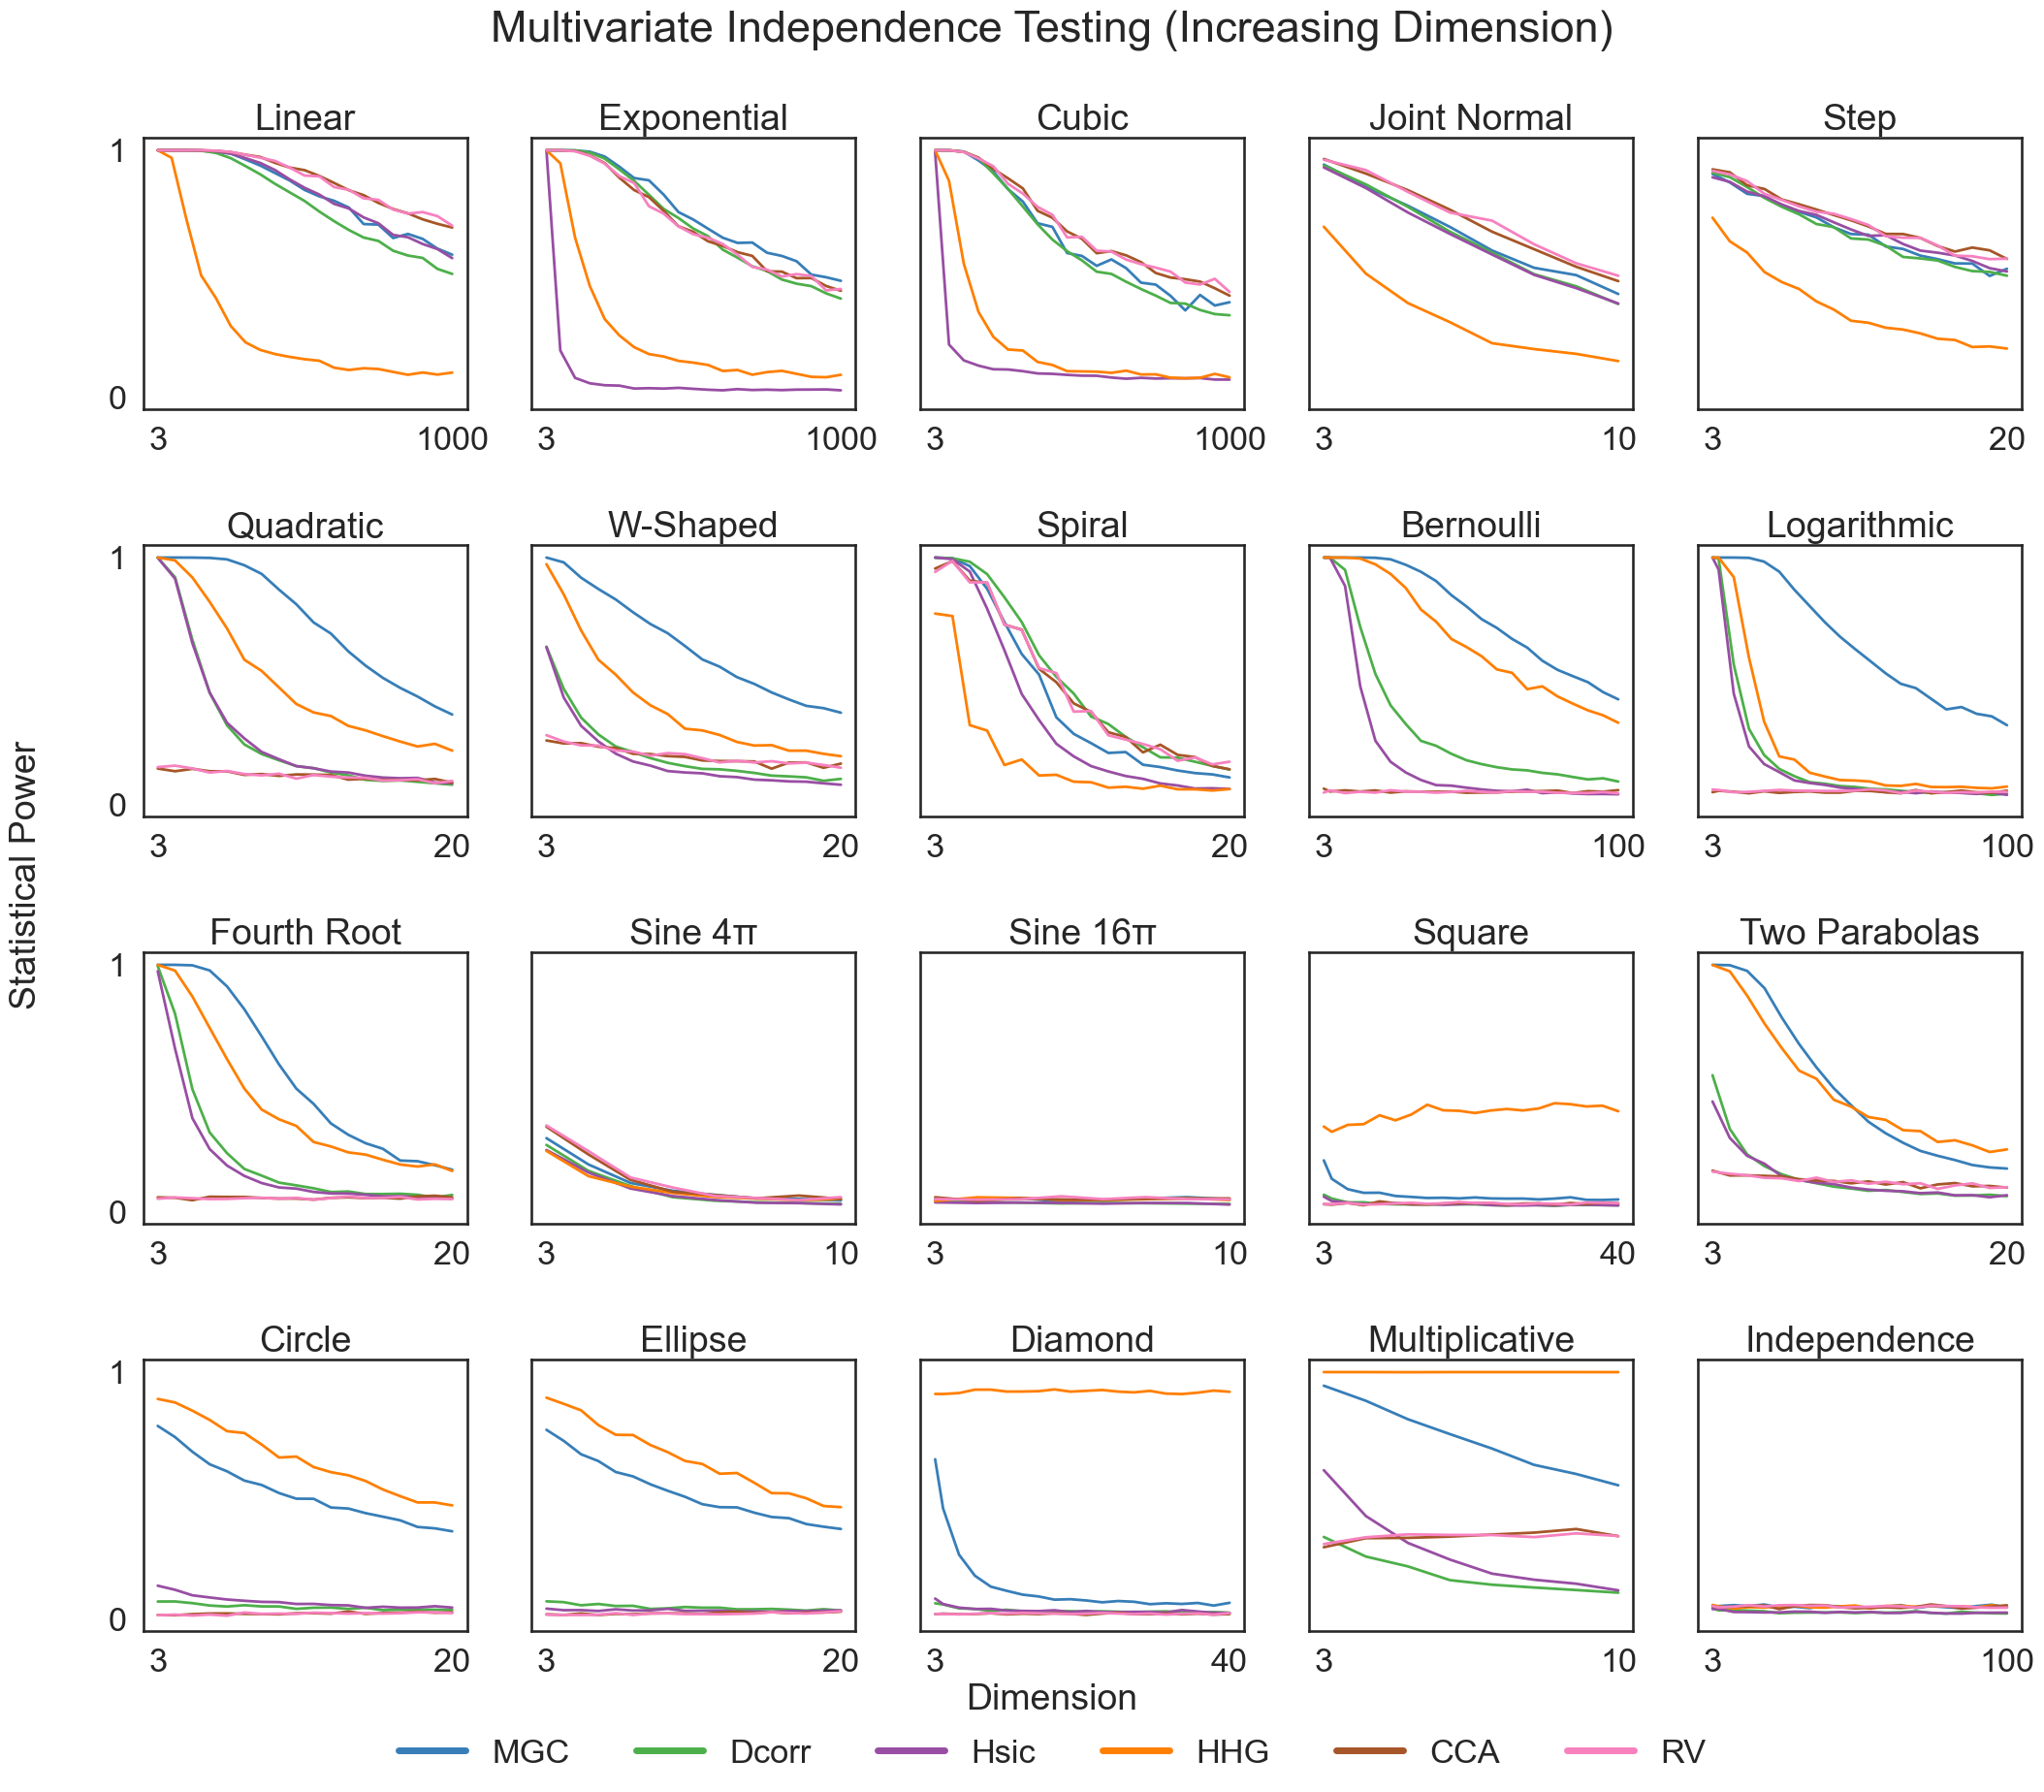

In [6]:
plot_power()